In [9]:
import nibabel as nib
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
import torch

In [5]:
TRAIN_DATASET_PATH = '../BraTS2021_Training_Data/'

## pre-processing (creating 2d slices dataset)

In [134]:
t2_list = sorted(glob('../BraTS2021_Training_Data/*/*t2.nii.gz'))
# glob returns a list of paths matching the given pattern != from os.listdir that does not return entire paths
print('t2_list', t2_list)

t1ce_list = sorted(glob('../BraTS2021_Training_Data/*/*t1ce.nii.gz'))

flair_list = sorted(glob('../BraTS2021_Training_Data/*/*flair.nii.gz'))

mask_list = sorted(glob('../BraTS2021_Training_Data/*/*seg.nii.gz'))



for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    # Crop to a size to be divisible by 64
    #temp_combined_images=temp_combined_images[24:216, 24:216, 13:141] ---> 192, 192, 128
    #temp_mask = temp_mask[24:216, 24:216, 13:141]
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    for slice in range(temp_mask.shape[2]):
        val, counts = np.unique(temp_mask[:,:,slice], return_counts=True)
        if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
            print("Save Me")

            slice_mask = temp_mask[:,:,slice]
            temp_mask_one_hot = torch.zeros((*slice_mask.shape, 4), dtype=torch.float32)
            temp_mask_one_hot.scatter_(2, torch.unsqueeze(torch.tensor(slice_mask, dtype=torch.int64), 2), 1)
            
            output_dir = 'BraTS2021_TrainingData/input_data_3channels'
            image_dir = os.path.join(output_dir, 'images')
            mask_dir = os.path.join(output_dir, 'masks')
            os.makedirs(image_dir, exist_ok=True)
            os.makedirs(mask_dir, exist_ok=True)
            np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str(img)+'_'+str(slice)+'.npy', temp_combined_images[:,:,slice,:])
            np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str(img)+'_'+str(slice)+'.npy', temp_mask_one_hot)
            
        else:
            print("I am useless") 
   
     
# Split training data into train and validation

"""
NOW: splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
"""
import splitfolders  # or import split_folders

input_folder = 'BraTS2021_TrainingData/input_data_3channels/'
output_folder = 'BraTS2021_TrainingData/input_data_128/'

# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # default values

t2_list ['environment_1/BraTS2021_Training_Data/BraTS2021_00002/BraTS2021_00002_t2.nii.gz', 'environment_1/BraTS2021_Training_Data/BraTS2021_00003/BraTS2021_00003_t2.nii.gz']
Now preparing image and masks number:  0
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me
Save Me

## example of procedure on one volume

In [83]:
temp_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00002/BraTS2021_00002_t2.nii.gz').get_fdata()
temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

temp_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz').get_fdata()
temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

temp_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00002/BraTS2021_00002_flair.nii.gz').get_fdata()
temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
temp_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00002/BraTS2021_00002_seg.nii.gz').get_fdata()
temp_mask=temp_mask.astype(np.uint8)
temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

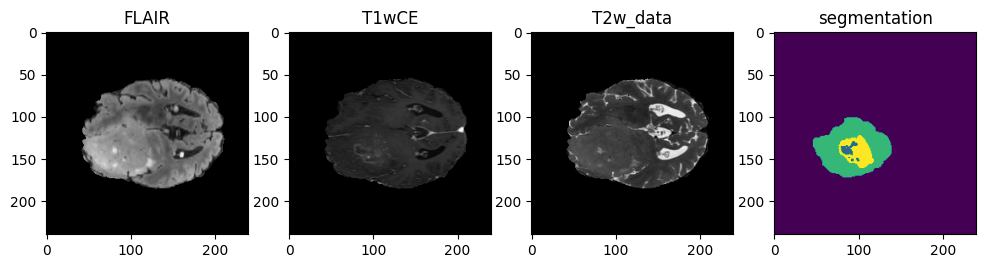

In [85]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(141)
plt.title('FLAIR')
plt.imshow(temp_image_flair[:,:,slice], cmap='gray') # we are selecting slice 70 (in total there are 155 per volume)
plt.subplot(142)
plt.title('T1wCE')
plt.imshow(temp_image_t1ce[:,:,slice], cmap='gray')
plt.subplot(143)
plt.title('T2w_data')
plt.imshow(temp_image_t2[:,:,slice], cmap='gray')
plt.subplot(144)
plt.title('segmentation')
plt.imshow(temp_mask[:,:,slice])

In [86]:
temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
temp_combined_images.shape

(240, 240, 155, 3)

In [87]:
temp_combined_images = temp_combined_images[24:216, 24:216, 13:141] # crop to 192 x 192 x 128 x 3
temp_mask = temp_mask[24:216, 24:216, 13:141]
temp_mask.shape

(192, 192, 128)

In [88]:
val, counts = np.unique(temp_mask, return_counts=True)
print(val, counts)

[0 1 2 3] [4527998   11248  155695   23651]


In [89]:
for slice in range(temp_mask.shape[2]):
    val, counts = np.unique(temp_mask[:,:,slice], return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")

        slice_mask = temp_mask[:,:,slice]
        temp_mask_one_hot = torch.zeros((*slice_mask.shape, 4), dtype=torch.float32)
        temp_mask_one_hot.scatter_(2, torch.unsqueeze(torch.tensor(slice_mask, dtype=torch.int64), 2), 1)
        
        output_dir = 'BraTS2021_TrainingData/input_data_3channels'
        image_dir = os.path.join(output_dir, 'images')
        mask_dir = os.path.join(output_dir, 'masks')
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)
        np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str('slice'+str(slice))+'.npy', temp_combined_images[:,:,slice,:])
        np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str('slice'+str(slice))+'.npy', temp_mask_one_hot)
        
    else:
        print("I am useless") 

I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
I am useless
Save Me
[0 2] [36464   400]
Save Me
[0 2] [36408   456]
Save Me
[0 2] [36276   588]
Save Me
[0 2] [36269   595]
Save Me
[0 2] [36219   645]
Save Me
[0 2] [36179   685]
Save Me
[0 2] [36190   674]
Save Me
[0 2] [36167   697]
Save Me
[0 2] [36141   723]
Save Me
[0 2] [36063   801]
Save Me
[0 2] [36104   760]
Save Me
[0 2] [36106   758]
Save Me
[0 2] [36137   727]
Save Me
[0 2] [36095   769]
Save Me
[0 2] [35748  1116]
Save Me
[0 2] [35703  1161]
Save Me
[0 2] [35111  1753]
Save Me
[0 2] [35190  1674]
Save Me
[0 2] [34867  1997]
Save Me
[0 2] [34489  2375]
Save Me
[0 2] [34531  2333]
Save Me
[0 2 3] [34532  2276    56]
Save Me
[0 2

In [90]:
print(temp_mask_one_hot.shape)

torch.Size([192, 192, 4])


In [139]:
my_img=np.load('BraTS2021_TrainingData/input_data_128/train/images/image_0_36.npy')
my_mask=np.load('BraTS2021_TrainingData/input_data_128/train/masks/mask_0_36.npy')

In [114]:
print(my_img.shape)
print(my_mask.shape)

(192, 192, 3)
(192, 192, 4)


In [140]:
test_mask=np.argmax(my_mask, axis=2)

In [137]:
print(test_mask.shape)

(128, 128)


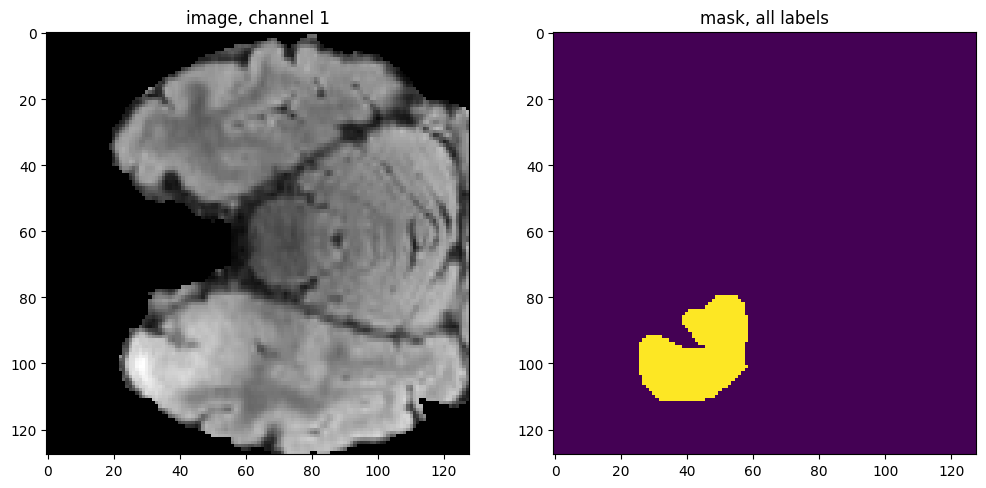

In [141]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('image, channel 1')
plt.imshow(my_img[:,:,0], cmap= 'gray')
plt.subplot(122)
plt.title('mask, all labels')
plt.imshow(test_mask[:,:]) 